In [1]:
from mne_bids import (BIDSPath,read_raw_bids)
import mne_bids
import mne
import importlib
import ccs_eeg_utils
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as plt

/home/yannick/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def plot_data(data, sampling_rate=500, seconds=7):
    num_points = seconds * sampling_rate + 1
    plt.plot(np.arange(num_points) / sampling_rate, data[0][0].T[:num_points])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("EEG Signal")
    plt.show()


In [3]:
bids_root = "./data/"
subject_id = '001'


bids_path = BIDSPath(subject=subject_id, run="02", task="ContinuousVideoGamePlay",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)
clear_output()

In [4]:
raw.load_data()
raw_unmodified = raw.copy()

Reading 0 ... 1398674  =      0.000 ...  2797.348 secs...


In [5]:
raw = raw_unmodified.copy()

In [6]:
#Pipeline as suggested by paper
#plot_data(raw)
raw.filter(0.01, 0.1, picks="all")
#plot_data(raw)
raw.apply_hilbert(picks="all")
# plot_data(raw)
# raw.resample(100)
# plot_data(raw, 100)

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 165001 samples (330.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


<RawEEGLAB | sub-001_task-ContinuousVideoGamePlay_run-02_eeg.fdt, 65 x 1398675 (2797.3 s), ~1.35 GB, data loaded>

In [7]:
raw = raw_unmodified.copy()
raw.filter(0.01, 0.1, picks="all")
raw.apply_hilbert(picks="all")
test = np.angle(raw.get_data(picks="all"))


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 165001 samples (330.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


In [8]:
test[12].shape

(1398675,)

In [9]:
def create_bins(data, num_bins=8):
    bin_size = 2 * np.pi / num_bins
    bins = []
    for i in range(num_bins):
        bins.append([])
    for element in data:
        bin_index = int((element + np.pi) // bin_size)
        bins[bin_index].append(element)
    return bins

In [10]:
bins = create_bins(test[12])

<BarContainer object of 8 artists>

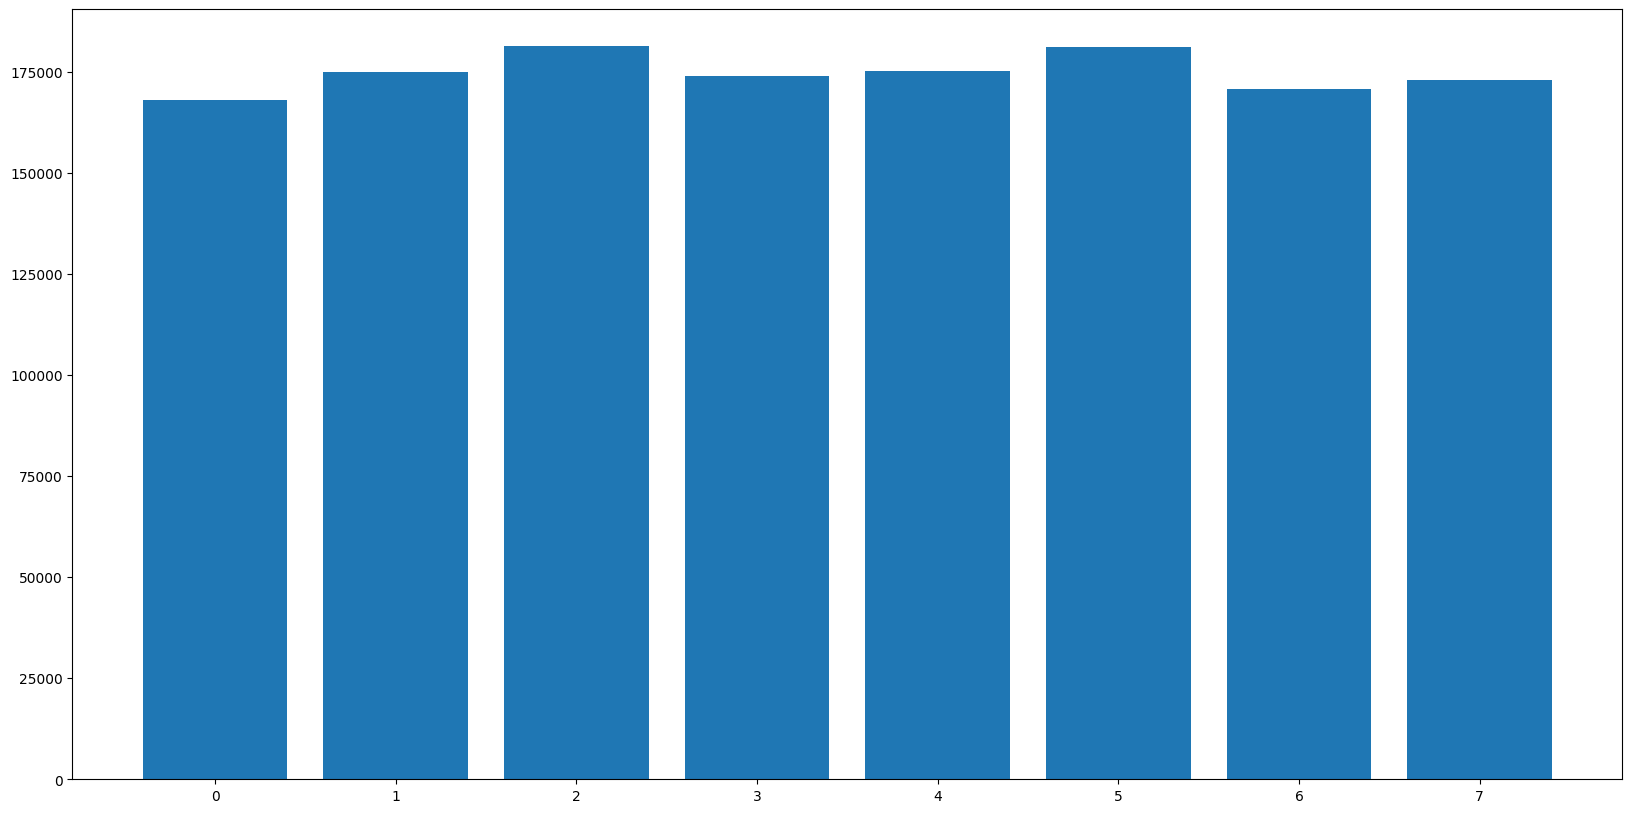

In [11]:
#plot angles
plt.figure(figsize=(20,10))
plt.bar([i for i in range(8)], [len(bins[i]) for i in range(8)])

## Compute bin standard deviation
- For each event calculate difference to standard deviation

In [32]:
def get_bin_probabilities(bins):
    sum = 0
    for bin in bins:
        sum += len(bin)
    return [len(bin)/sum for bin in bins]

def get_bin_deviation(data, timestamp, timespan = 0.1, sampling_rate = 500):
    bins = create_bins(data)
    default = get_bin_probabilities(bins)
    print(default)
    
    event_bins = create_bins(data[int((timestamp-timespan/2)*sampling_rate):int((timestamp+timespan/2)*sampling_rate)])
    event_probability = get_bin_probabilities(event_bins)
    print(event_probability)

    deviation = []
    for i  in range(len(default)):
        deviation.append(abs(default[i]-event_probability[i]))

    return deviation

In [37]:
deviation = get_bin_deviation(test[12], timestamp=110, timespan=10)
print(deviation)

[0.12021377375015639, 0.12512771015425314, 0.1297199134895526, 0.12437270988614224, 0.12537580209841456, 0.12952401379877385, 0.12205337194130159, 0.12361270488140562]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5342, 0.4658]
[0.12021377375015639, 0.12512771015425314, 0.1297199134895526, 0.12437270988614224, 0.12537580209841456, 0.12952401379877385, 0.4121466280586984, 0.34218729511859436]
